# Reinforcement Learning Individual Assignment


### Imports

In [ ]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-k6z8erax
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-k6z8erax
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 12.4 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7771 sha256=40e856e5c4dd72d0446e9cac0f31003830be2c7cbc2ba060d1f8e3e5af4d1240
  Stored in directory: /tmp/pip-ephem-wheel-cache-jfjo_3i9/wheels/a1/07/d2/74e9570f22696f6a81089c4e5dbe11248ff1e4b3236dafe59d
Successfully built text-flappy-bird-gym
  Attempting uninstall: gymnasium
    Found existing installation: gym

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from text_flappy_bird_env_screen import TextFlappyBirdEnvScreen
from text_flappy_bird_env_simple import TextFlappyBirdEnvSimple
import random
from collections import defaultdict
import gym
import text_flappy_bird_gym
import sys

The environment that will be solved in this notebook is TextFlappyBird-v0. Two distinct agents are implemented and studied: a Monte Carlo control agent
and a True Online Sarsa(λ) agent. Monte Carlo methods learn from complete
episodes by estimating value functions based on the average returns of sampled
trajectories. True Online Sarsa(λ), on the other hand, is an on-policy temporal-
difference method that incorporates eligibility traces to efficiently blend the
benefits of both Monte Carlo and traditional TD learning.

# Monte Carlo Control

In [ ]:
class MonteCarloAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, eps_start=0.2, eps_decay=0.999, eps_min=1e-4):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min

        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def get_probs(self, Q_s, epsilon):
        policy = np.ones(self.nA) * (epsilon / self.nA)
        best_action = np.argmax(Q_s)
        policy[best_action] += 1.0 - epsilon
        return policy

    def generate_episode(self, epsilon):
        episode = []
        state, _ = self.env.reset()

        while True:
            probs = self.get_probs(self.Q[state], epsilon) if state in self.Q else np.ones(self.nA) / self.nA
            action = np.random.choice(np.arange(self.nA), p=probs)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done:
                break

        return episode

    def update_Q(self, episode):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])

        for i, state in enumerate(states):
            G = sum(np.array(rewards[i:]) * discounts[:len(rewards[i:])])
            old_value = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_value + self.alpha * (G - old_value)

    def learn(self, num_episodes=10000):
        epsilon = self.eps_start
        rewards_per_episode = []

        for i in range(1, num_episodes + 1):
            epsilon = max(self.eps_min, epsilon * self.eps_decay)
            episode = self.generate_episode(epsilon)
            self.update_Q(episode)
            total_reward = sum([r for (_, _, r) in episode])
            rewards_per_episode.append(total_reward)

            if i % 100 == 0:
                print(f"Episode {i}/{num_episodes} - Total Reward: {total_reward:.2f}")

        self.policy = {s: np.argmax(a) for s, a in self.Q.items()}
        return rewards_per_episode

    def plot_rewards(self, rewards, window=50):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards, label='Reward per Episode', alpha=0.6)
        if len(rewards) >= window:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window - 1, len(rewards)), moving_avg, label=f'{window}-Episode Moving Avg')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Monte Carlo Control Performance')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [ ]:
def plot_rewards_multiple(rewards_list, window=50, labels=None):
    plt.figure(figsize=(10, 5))
    if labels is None:
        labels = [f"Rewards {i+1}" for i in range(len(rewards_list))]

    for i, rewards in enumerate(rewards_list):
        if len(rewards) >= window:
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            plt.plot(range(window - 1, len(rewards)), moving_avg,
                     label=f'{labels[i]} {window}-Episode Moving Avg')

    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Monte Carlo Control Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_state_value_function_montecarlo(agent, env):
    x_space = env.observation_space.spaces[0].n
    y_space = env.observation_space.spaces[1].n
    y_start = env.observation_space.spaces[1].start if hasattr(env.observation_space.spaces[1], 'start') else 0
    state_values = np.zeros((y_space, x_space))

    for x in range(x_space):
        for i in range(y_space):
            y = y_start + i
            state = (x, y)
            if state in agent.Q:
                state_values[i, x] = np.max(agent.Q[state])
            else:
                state_values[i, x] = 0.0

    plt.figure(figsize=(8, 6))
    extent = [0, x_space - 1, y_start, y_start + y_space - 1]
    plt.imshow(state_values, origin='lower', extent=extent, aspect='auto')
    plt.xlabel("dx")
    plt.ylabel("dy")
    plt.title("Value function")
    plt.colorbar(label="Q-value")
    plt.show()

### Parameter sweep for Monte Carlo Control

We test different values of `eps_start`.

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc_eps_0_5 = MonteCarloAgent(env,eps_start=0.5)
rewards_mc_eps_0_5 = agent_mc_eps_0_5.learn(num_episodes=4200)

Episode 100/4200 - Total Reward: 4.00
Episode 200/4200 - Total Reward: 13.00
Episode 300/4200 - Total Reward: 6.00
Episode 400/4200 - Total Reward: 33.00
Episode 500/4200 - Total Reward: 71.00
Episode 600/4200 - Total Reward: 43.00
Episode 700/4200 - Total Reward: 4.00
Episode 800/4200 - Total Reward: 67.00
Episode 900/4200 - Total Reward: 33.00
Episode 1000/4200 - Total Reward: 92.00
Episode 1100/4200 - Total Reward: 15.00
Episode 1200/4200 - Total Reward: 32.00
Episode 1300/4200 - Total Reward: 133.00
Episode 1400/4200 - Total Reward: 76.00
Episode 1500/4200 - Total Reward: 46.00
Episode 1600/4200 - Total Reward: 17.00
Episode 1700/4200 - Total Reward: 28.00
Episode 1800/4200 - Total Reward: 13.00
Episode 1900/4200 - Total Reward: 153.00
Episode 2000/4200 - Total Reward: 113.00
Episode 2100/4200 - Total Reward: 153.00
Episode 2200/4200 - Total Reward: 364.00
Episode 2300/4200 - Total Reward: 283.00
Episode 2400/4200 - Total Reward: 13.00
Episode 2500/4200 - Total Reward: 180.00
Episo

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc_eps_0_2 = MonteCarloAgent(env,eps_start=0.2)
rewards_mc_eps_0_2 = agent_mc_eps_0_2.learn(num_episodes=4200)

Episode 100/4200 - Total Reward: 11.00
Episode 200/4200 - Total Reward: 13.00
Episode 300/4200 - Total Reward: 13.00
Episode 400/4200 - Total Reward: 13.00
Episode 500/4200 - Total Reward: 18.00
Episode 600/4200 - Total Reward: 27.00
Episode 700/4200 - Total Reward: 13.00
Episode 800/4200 - Total Reward: 23.00
Episode 900/4200 - Total Reward: 173.00
Episode 1000/4200 - Total Reward: 29.00
Episode 1100/4200 - Total Reward: 33.00
Episode 1200/4200 - Total Reward: 66.00
Episode 1300/4200 - Total Reward: 23.00
Episode 1400/4200 - Total Reward: 133.00
Episode 1500/4200 - Total Reward: 347.00
Episode 1600/4200 - Total Reward: 167.00
Episode 1700/4200 - Total Reward: 107.00
Episode 1800/4200 - Total Reward: 153.00
Episode 1900/4200 - Total Reward: 253.00
Episode 2000/4200 - Total Reward: 763.00
Episode 2100/4200 - Total Reward: 523.00
Episode 2200/4200 - Total Reward: 233.00
Episode 2300/4200 - Total Reward: 303.00
Episode 2400/4200 - Total Reward: 23.00
Episode 2500/4200 - Total Reward: 284.

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc_eps_0_1 = MonteCarloAgent(env, eps_start=0.1)
rewards_mc_eps_0_1 = agent_mc_eps_0_1.learn(num_episodes=4200)

Episode 100/4200 - Total Reward: 22.00
Episode 200/4200 - Total Reward: 33.00
Episode 300/4200 - Total Reward: 13.00
Episode 400/4200 - Total Reward: 23.00
Episode 500/4200 - Total Reward: 15.00
Episode 600/4200 - Total Reward: 87.00
Episode 700/4200 - Total Reward: 47.00
Episode 800/4200 - Total Reward: 43.00
Episode 900/4200 - Total Reward: 42.00
Episode 1000/4200 - Total Reward: 22.00
Episode 1100/4200 - Total Reward: 26.00
Episode 1200/4200 - Total Reward: 163.00
Episode 1300/4200 - Total Reward: 46.00
Episode 1400/4200 - Total Reward: 73.00
Episode 1500/4200 - Total Reward: 63.00
Episode 1600/4200 - Total Reward: 83.00
Episode 1700/4200 - Total Reward: 37.00
Episode 1800/4200 - Total Reward: 63.00
Episode 1900/4200 - Total Reward: 70.00
Episode 2000/4200 - Total Reward: 293.00
Episode 2100/4200 - Total Reward: 80.00
Episode 2200/4200 - Total Reward: 23.00
Episode 2300/4200 - Total Reward: 177.00
Episode 2400/4200 - Total Reward: 228.00
Episode 2500/4200 - Total Reward: 198.00
Epis

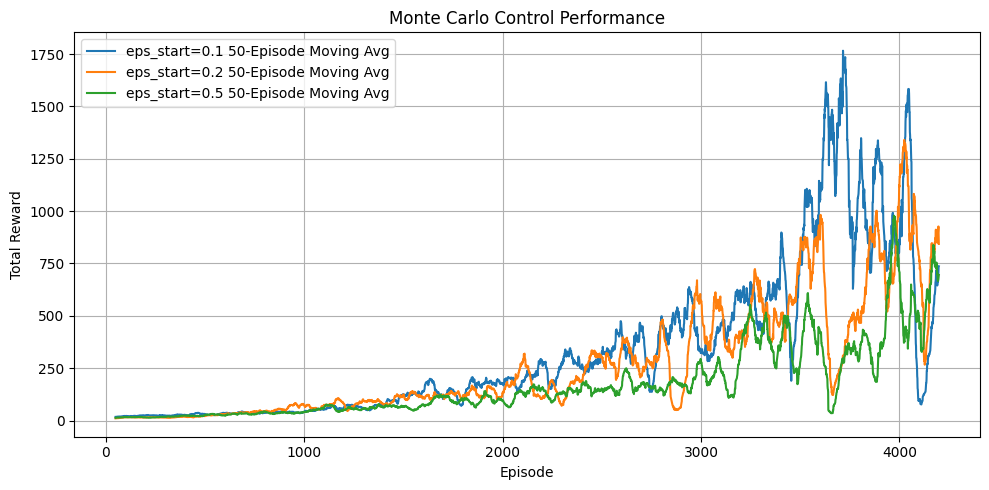

In [ ]:
plot_rewards_multiple([rewards_mc_eps_0_1,rewards_mc_eps_0_2,rewards_mc_eps_0_5],labels=["eps_start=0.1","eps_start=0.2","eps_start=0.5"])

We are now going to test different values of `alpha`.

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc_alpha_0_1 = MonteCarloAgent(env, alpha=0.1)
rewards_mc_alpha_0_1 = agent_mc_alpha_0_1.learn(num_episodes=4200)

Episode 100/4200 - Total Reward: 10.00
Episode 200/4200 - Total Reward: 12.00
Episode 300/4200 - Total Reward: 17.00
Episode 400/4200 - Total Reward: 33.00
Episode 500/4200 - Total Reward: 33.00
Episode 600/4200 - Total Reward: 12.00
Episode 700/4200 - Total Reward: 43.00
Episode 800/4200 - Total Reward: 23.00
Episode 900/4200 - Total Reward: 13.00
Episode 1000/4200 - Total Reward: 33.00
Episode 1100/4200 - Total Reward: 53.00
Episode 1200/4200 - Total Reward: 5.00
Episode 1300/4200 - Total Reward: 33.00
Episode 1400/4200 - Total Reward: 123.00
Episode 1500/4200 - Total Reward: 33.00
Episode 1600/4200 - Total Reward: 103.00
Episode 1700/4200 - Total Reward: 78.00
Episode 1800/4200 - Total Reward: 13.00
Episode 1900/4200 - Total Reward: 103.00
Episode 2000/4200 - Total Reward: 163.00
Episode 2100/4200 - Total Reward: 153.00
Episode 2200/4200 - Total Reward: 423.00
Episode 2300/4200 - Total Reward: 107.00
Episode 2400/4200 - Total Reward: 82.00
Episode 2500/4200 - Total Reward: 32.00
Epi

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc_alpha_0_2 = MonteCarloAgent(env, alpha=0.2)
rewards_mc_alpha_0_2 = agent_mc_alpha_0_2.learn(num_episodes=4200)

Episode 100/4200 - Total Reward: 20.00
Episode 200/4200 - Total Reward: 19.00
Episode 300/4200 - Total Reward: 23.00
Episode 400/4200 - Total Reward: 53.00
Episode 500/4200 - Total Reward: 12.00
Episode 600/4200 - Total Reward: 53.00
Episode 700/4200 - Total Reward: 13.00
Episode 800/4200 - Total Reward: 13.00
Episode 900/4200 - Total Reward: 180.00
Episode 1000/4200 - Total Reward: 43.00
Episode 1100/4200 - Total Reward: 73.00
Episode 1200/4200 - Total Reward: 26.00
Episode 1300/4200 - Total Reward: 633.00
Episode 1400/4200 - Total Reward: 103.00
Episode 1500/4200 - Total Reward: 33.00
Episode 1600/4200 - Total Reward: 93.00
Episode 1700/4200 - Total Reward: 123.00
Episode 1800/4200 - Total Reward: 21.00
Episode 1900/4200 - Total Reward: 73.00
Episode 2000/4200 - Total Reward: 243.00
Episode 2100/4200 - Total Reward: 10.00
Episode 2200/4200 - Total Reward: 143.00
Episode 2300/4200 - Total Reward: 213.00
Episode 2400/4200 - Total Reward: 34.00
Episode 2500/4200 - Total Reward: 853.00
E

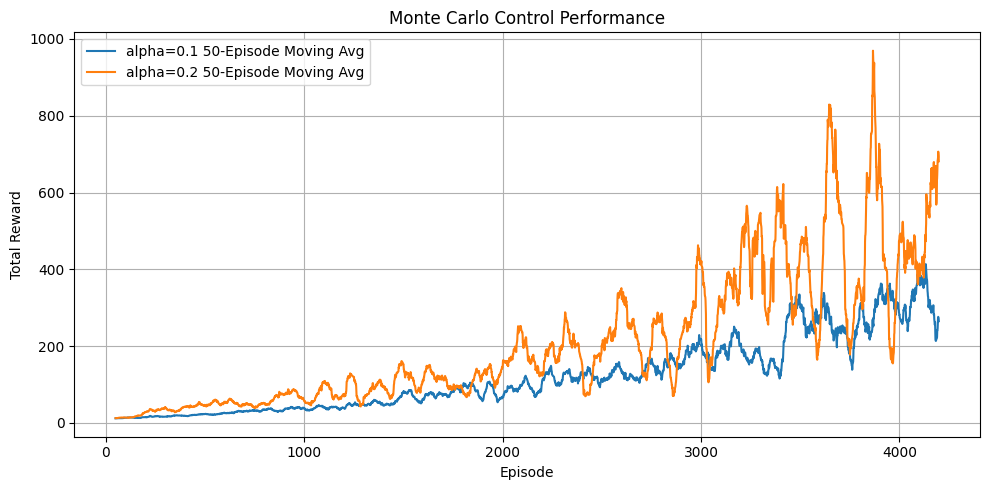

In [ ]:
plot_rewards_multiple([rewards_mc_alpha_0_1,rewards_mc_alpha_0_2],labels=["alpha=0.1","alpha=0.2"])

### MC reward after 5000 episodes

Episode 100/5000 - Total Reward: 13.00
Episode 200/5000 - Total Reward: 18.00
Episode 300/5000 - Total Reward: 16.00
Episode 400/5000 - Total Reward: 13.00
Episode 500/5000 - Total Reward: 26.00
Episode 600/5000 - Total Reward: 79.00
Episode 700/5000 - Total Reward: 173.00
Episode 800/5000 - Total Reward: 13.00
Episode 900/5000 - Total Reward: 13.00
Episode 1000/5000 - Total Reward: 293.00
Episode 1100/5000 - Total Reward: 202.00
Episode 1200/5000 - Total Reward: 193.00
Episode 1300/5000 - Total Reward: 123.00
Episode 1400/5000 - Total Reward: 313.00
Episode 1500/5000 - Total Reward: 103.00
Episode 1600/5000 - Total Reward: 113.00
Episode 1700/5000 - Total Reward: 44.00
Episode 1800/5000 - Total Reward: 113.00
Episode 1900/5000 - Total Reward: 19.00
Episode 2000/5000 - Total Reward: 173.00
Episode 2100/5000 - Total Reward: 58.00
Episode 2200/5000 - Total Reward: 543.00
Episode 2300/5000 - Total Reward: 273.00
Episode 2400/5000 - Total Reward: 1283.00
Episode 2500/5000 - Total Reward: 2

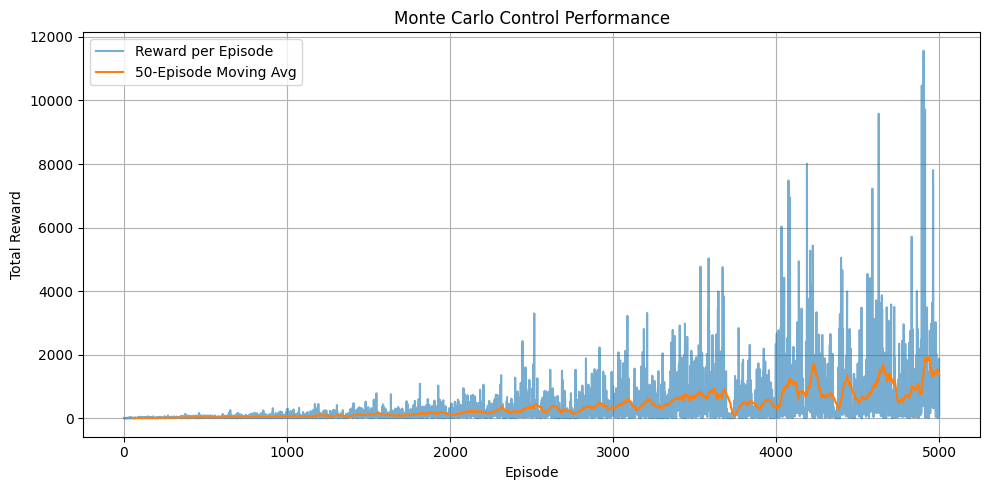

In [ ]:
env = TextFlappyBirdEnvSimple()
agent_mc = MonteCarloAgent(env)

rewards_mc = agent_mc.learn(num_episodes=5000)
agent_mc.plot_rewards(rewards_mc)

### Monte Carlo Control State-Value function

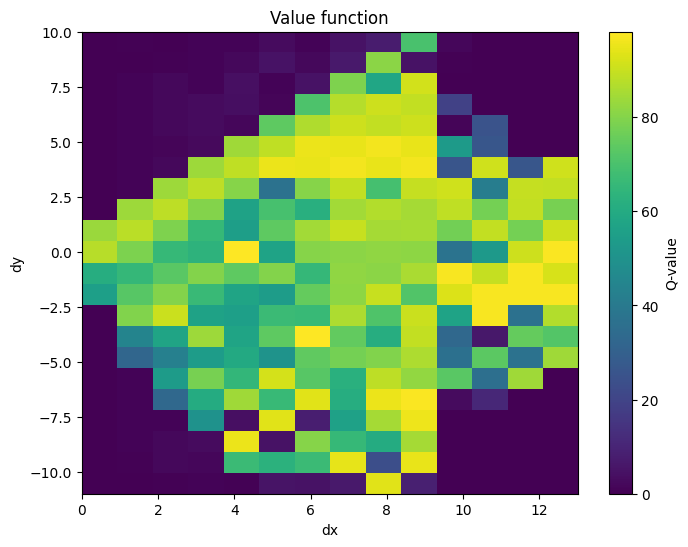

In [ ]:
plot_state_value_function_montecarlo(agent_mc,TextFlappyBirdEnvSimple())

# True Online SARSA

In [ ]:
class TrueOnlineSarsaLambdaAgent:
    def agent_init(self, agent_init_info):

        self.num_states = agent_init_info["num_states"]
        self.num_actions = agent_init_info["num_actions"]
        self.alpha = agent_init_info["alpha"]
        self.gamma = agent_init_info["gamma"]
        self.lambda_ = agent_init_info["lambda_"]
        self.epsilon = agent_init_info['epsilon']
        self.eps_decay = agent_init_info['eps_decay']
        self.eps_min = agent_init_info['eps_min']
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        self.feature_dim = self.num_states * self.num_actions

        # Weight vector w in R^d, one eligibility trace vector z in R^d
        self.w = np.zeros(self.feature_dim)
        self.z = np.zeros(self.feature_dim)

        self.state_dict = {}
        self.state_count = 0

        self.x = None
        self.Q_old = 0

    def _ensure_state_exists(self, state):
        if state not in self.state_dict:
            self.state_dict[state] = self.state_count
            self.state_count += 1

    def _phi(self, state_idx, action):
        x = np.zeros(self.feature_dim)
        feature_index = state_idx * self.num_actions + action
        x[feature_index] = 1.0
        return x

    def _q_hat(self, x):
        return np.dot(self.w, x)

    def _choose_action(self, state_idx):
        qvals = []
        for a in range(self.num_actions):
            x_sa = self._phi(state_idx, a)
            qvals.append(self._q_hat(x_sa))
        qvals = np.array(qvals)

        # Epsilon-greedy
        if self.rand_generator.rand() < self.epsilon:
            return self.rand_generator.randint(self.num_actions)
        else:
            max_q = np.max(qvals)
            # Break ties randomly
            best_actions = np.where(qvals == max_q)[0]
            return self.rand_generator.choice(best_actions)

    def agent_start(self, state):
        # Decay epsilon at the start of each episode
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        # Reset eligibility traces, Q_old
        self.z = np.zeros_like(self.w)
        self.Q_old = 0

        # Ensure state index exists
        self._ensure_state_exists(state)
        state_idx = self.state_dict[state]

        # Choose action
        action = self._choose_action(state_idx)

        # Build feature vector x(s,a)
        self.x = self._phi(state_idx, action)

        return action

    def agent_step(self, reward, state):
        self._ensure_state_exists(state)
        state_idx = self.state_dict[state]

        # We choose the next action
        next_action = self._choose_action(state_idx)
        x_prime = self._phi(state_idx, next_action)

        # Q, Q'
        Q = self._q_hat(self.x)
        Q_prime = self._q_hat(x_prime)

        # δ
        delta = reward + self.gamma * Q_prime - Q

        # We update eligibility trace
        #   z = γλ z + [1 - α γ λ xᵗ z] x
        x_dot_z = np.dot(self.x, self.z)
        self.z = self.gamma * self.lambda_ * self.z + (1.0 - self.alpha * self.gamma * self.lambda_ * x_dot_z) * self.x

        # We update the weights
        #   w = w + α [(δ + Q - Q_old) z - (Q - Q_old) x]
        correction_term = (Q - self.Q_old)
        self.w += self.alpha * ((delta + correction_term) * self.z - correction_term * self.x)

        # Q_old, x
        self.Q_old = Q_prime
        self.x = x_prime

        return next_action

    def agent_end(self, reward):
        Q = self._q_hat(self.x)
        delta = reward - Q

        x_dot_z = np.dot(self.x, self.z)
        self.z = self.gamma * self.lambda_ * self.z + (1.0 - self.alpha * self.gamma * self.lambda_ * x_dot_z) * self.x

        correction_term = (Q - self.Q_old)
        self.w += self.alpha * ((delta + correction_term) * self.z - correction_term * self.x)

    def get_Q(self, state, action):
        if state not in self.state_dict:
            return 0.0
        idx = self.state_dict[state]
        x_sa = self._phi(idx, action)
        return self._q_hat(x_sa)


In [ ]:
def train_true_online_sarsa_agent(num_episodes=1000, seed=42):

    env = TextFlappyBirdEnvSimple()
    x_space = env.observation_space[0].n
    y_space = env.observation_space[1].n
    num_states = x_space * y_space
    num_actions = env.action_space.n

    agent = TrueOnlineSarsaLambdaAgent()
    agent.agent_init({
        "num_states": num_states,
        "num_actions": num_actions,
        "alpha": 0.1,        # step-size
        "gamma": 0.99,        # discount
        "lambda_": 0.9,       # trace decay
        "epsilon": 0.2,       # initial eps
        "eps_decay": 0.999,   # decay factor
        "eps_min": 1e-4,      # min epsilon
        "seed": seed
    })

    returns = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        action = agent.agent_start(state)
        done = False
        total_reward = 0.0

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward

            if not done:
                action = agent.agent_step(reward, next_state)
            else:
                agent.agent_end(reward)

        returns.append(total_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Return = {total_reward:.2f}")

    return returns, agent

def plot_returns(returns, window=50):
    plt.figure(figsize=(10,5))
    plt.plot(returns, label="True Online SARSA(λ) - Episode Returns", alpha=0.6)
    if len(returns) >= window:
        avg_returns = np.convolve(returns, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(returns)), avg_returns, label=f"{window}-episode MA")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("True Online SARSA(λ) Performance on Text Flappy Bird")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_state_value_function(agent, env):
    x_space = env.observation_space.spaces[0].n
    y_space = env.observation_space.spaces[1].n
    y_start = env.observation_space.spaces[1].start if hasattr(env.observation_space.spaces[1], 'start') else 0
    state_values = np.zeros((y_space, x_space))

    for x in range(x_space):
        for i in range(y_space):
            y = y_start + i
            state = (x, y)
            q_vals = [agent.get_Q(state, a) for a in range(agent.num_actions)]
            state_values[i, x] = max(q_vals)

    plt.figure(figsize=(8, 6))
    extent = [0, x_space - 1, y_start, y_start + y_space - 1]
    plt.imshow(state_values, origin='lower', extent=extent, aspect='auto')
    plt.xlabel("dx")
    plt.ylabel("dy")
    plt.title("Value function")
    plt.colorbar(label="Q-value")
    plt.show()


### True Online Sarsa reward after 7000 episodes

Episode 100/7000, Return = 23.00
Episode 200/7000, Return = 24.00
Episode 300/7000, Return = 5.00
Episode 400/7000, Return = 113.00
Episode 500/7000, Return = 23.00
Episode 600/7000, Return = 23.00
Episode 700/7000, Return = 73.00
Episode 800/7000, Return = 61.00
Episode 900/7000, Return = 18.00
Episode 1000/7000, Return = 93.00
Episode 1100/7000, Return = 43.00
Episode 1200/7000, Return = 43.00
Episode 1300/7000, Return = 13.00
Episode 1400/7000, Return = 10.00
Episode 1500/7000, Return = 33.00
Episode 1600/7000, Return = 324.00
Episode 1700/7000, Return = 13.00
Episode 1800/7000, Return = 113.00
Episode 1900/7000, Return = 368.00
Episode 2000/7000, Return = 219.00
Episode 2100/7000, Return = 63.00
Episode 2200/7000, Return = 210.00
Episode 2300/7000, Return = 83.00
Episode 2400/7000, Return = 43.00
Episode 2500/7000, Return = 999.00
Episode 2600/7000, Return = 938.00
Episode 2700/7000, Return = 683.00
Episode 2800/7000, Return = 223.00
Episode 2900/7000, Return = 1940.00
Episode 3000

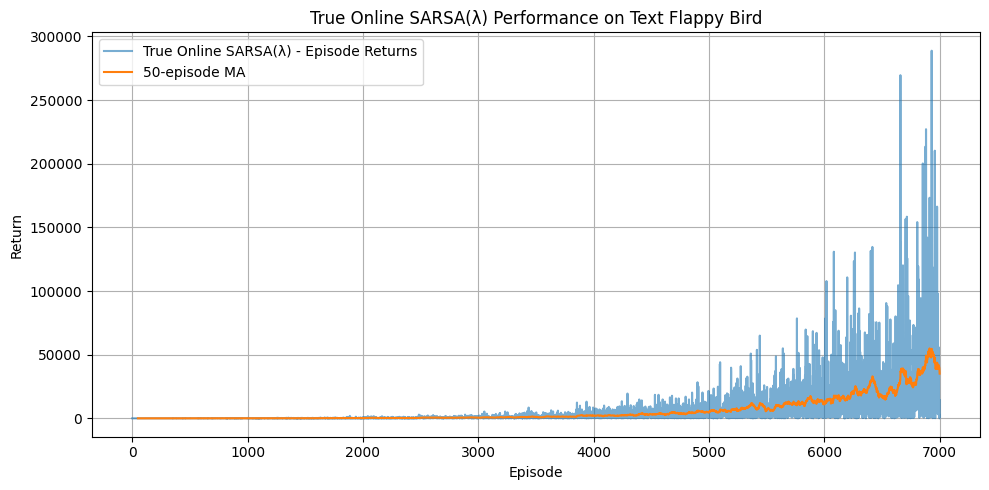

In [ ]:
returns, agent = train_true_online_sarsa_agent(num_episodes=7000)
plot_returns(returns)

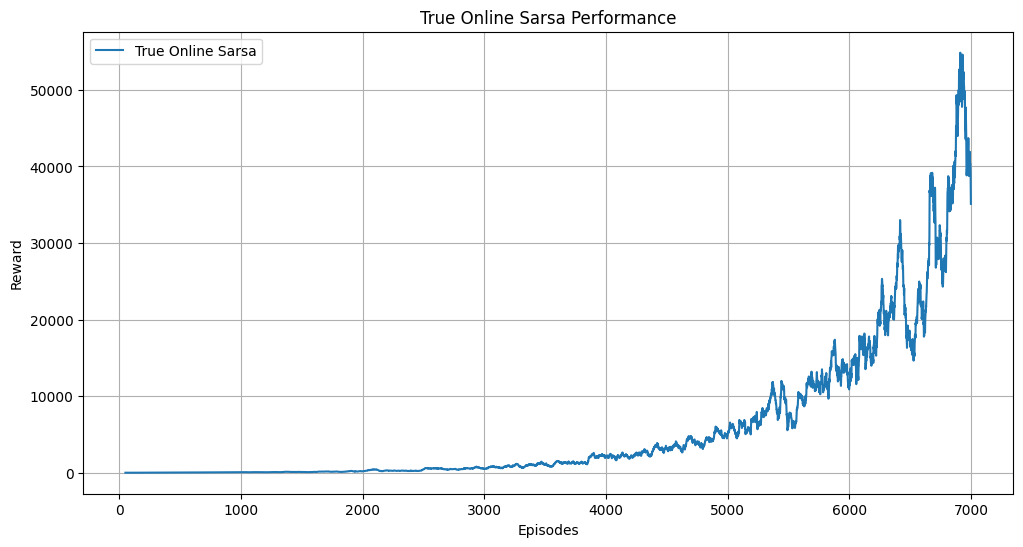

In [ ]:
import pandas as pd
plt.figure(figsize=(12,6))
plt.plot(pd.Series(returns).rolling(window=50).mean(),label="True Online Sarsa")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("True Online Sarsa Performance")
plt.legend()
plt.grid()
plt.show()

### State-Value function for True Online Sarsa

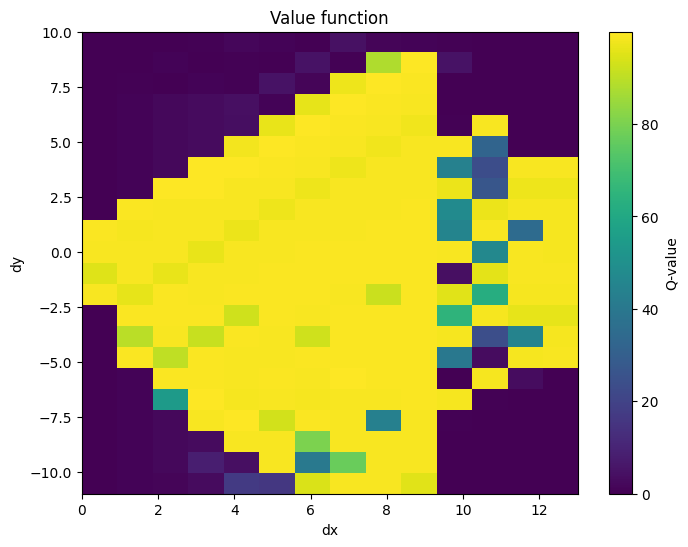

In [ ]:
plot_state_value_function(agent, TextFlappyBirdEnvSimple())

### Performance comparison over 5000 episodes

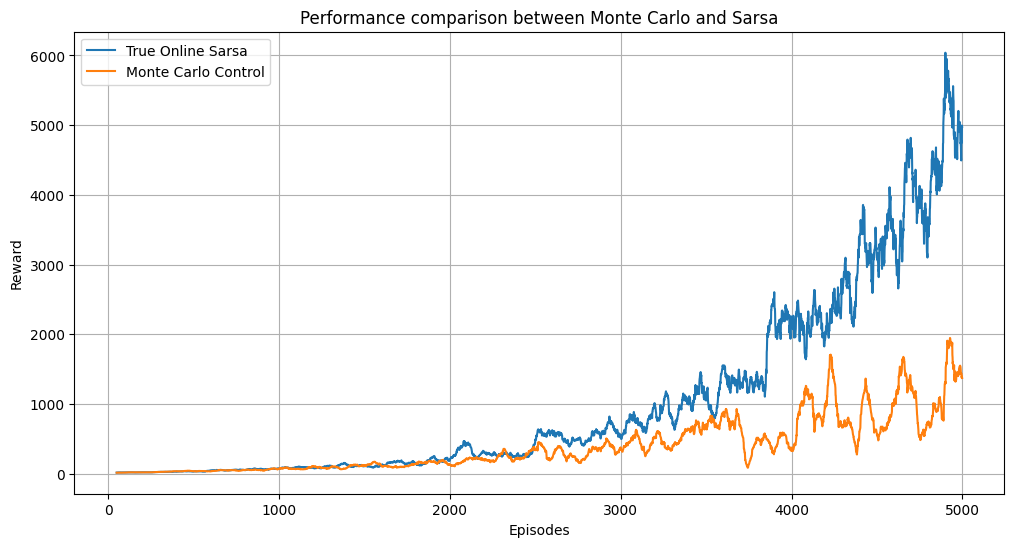

In [ ]:
import pandas as pd
plt.figure(figsize=(12,6))
plt.plot(pd.Series(returns).rolling(window=50).mean()[:5000],label="True Online Sarsa")
plt.plot(pd.Series(rewards_mc).rolling(window=50).mean(),label="Monte Carlo Control")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Performance comparison between Monte Carlo and Sarsa")
plt.legend()
plt.grid()
plt.show()